In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import least_squares, minimize
from sklearn import linear_model
import random
import cma
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
import datetime


In [2]:
def f(tc, t, beta):
    return (abs(tc-t))**beta
def g(tc, t, beta, omega):
    return f(tc, t, beta)*np.cos(omega*np.log(abs(tc-t)))
def h(tc, t, beta, omega):
    return f(tc, t, beta)*np.sin(omega*np.log(abs(tc-t)))

In [3]:
def LPPL(t, A, B, C1, C2, beta, omega, tc):
    return A + B*f(tc, t, beta) + C1*g(tc, t, beta, omega) + C2*h(tc, t, beta, omega)

In [4]:
def XOLS(beta, omega, tc, log_price):
    one_col = np.ones(len(log_price))

    t = np.arange(1,len(log_price)+1)
    f_col = f(tc=tc, t=t, beta=beta)
    g_col = g(tc=tc, t=t, beta=beta, omega=omega)
    h_col = h(tc=tc, t=t, beta=beta, omega=omega)

    X = np.array([one_col,f_col,g_col,h_col]).T

    return np.linalg.matrix_rank(X), X

In [5]:
def fit_ABC(beta, omega, tc, log_price):
    r, X = XOLS(beta, omega, tc, log_price)
    if r > 0:
        A, B, C1, C2 = np.linalg.lstsq(X, log_price)[0]
    else:
        #print('rank null')
        A = np.nan
        B = np.nan
        C1 = np.nan
        C2 = np.nan
    return {"A":A, "B":B, "C1":C1, "C2":C2}

In [6]:
def opti_config(log_price):
    beta_m = 0.01
    omega_m = 0

    beta_M = 1.5
    omega_M = 27

    t_first = 0
    t_last = len(log_price)
    t_delta = t_last - t_first
    pct_delta_min = t_delta * 0.2
    pct_delta_max = t_delta * 0.2
    tc_m = t_last - pct_delta_min
    tc_M = t_last + pct_delta_max

    return {"beta_m":beta_m, "omega_m":omega_m, "tc_m":tc_m, "beta_M":beta_M, "omega_M":omega_M, "tc_M":tc_M}

In [9]:
def wrapper_scaling(x,log_price):
    tc_s = x[0]
    beta_s = x[1]
    omega_s = x[2]
    return [len(log_price) + len(log_price)*0.2*np.cos(np.pi*tc_s/10), 1-np.cos(np.pi*beta_s/10), 1 + 49*(1-np.cos(np.pi*omega_s/10))/2]

In [10]:
def fit_cma(log_price):
    init_limits = [
        (4, 6), 
        (0, 5),                
        (1, 3),                     
    ]
    non_lin_vals = [random.uniform(a[0], a[1]) for a in init_limits]
    tc_0 = non_lin_vals[0]
    beta_0 = non_lin_vals[1]
    omega_0 = non_lin_vals[2]
    seed = np.array([tc_0, beta_0, omega_0])
        
    opti_sol = cma.fmin(lambda x: func(x,log_price),sigma0=2,x0=seed, options={ 'popsize':100})
    tc, beta, omega = wrapper_scaling(opti_sol[0],log_price)
    fit_res = fit_ABC(beta, omega, tc, log_price)
    normed_residual = func([tc, beta, omega],log_price)/len(log_price)
    sol = {'tc':tc, 'beta':beta, 'omega':omega, 'A':fit_res['A'], 'B':fit_res['B'], 'C1':fit_res['C1'], 'C2':fit_res['C2'], 'Res':normed_residual}
    return sol


In [11]:
def func(x, log_price):
    '''
    finds the least square difference
    '''
    tc, beta, omega = wrapper_scaling(x,log_price)
    # print('shape: {}'.format(obs.shape))
    fit = fit_ABC(beta, omega, tc, log_price)

    t = np.arange(len(log_price))

    return np.sum((LPPL(t=t, A=fit['A'], B=fit['B'], C1=fit['C1'], C2=fit['C2'], beta=beta, omega=omega, tc=tc)-log_price)**2)

In [12]:
def total_return(log_price):
    price = np.array(np.exp(log_price))
    return (price[-1]-price[0])/price[0]

In [13]:
def get_dt_max(sols, time_windows):
    residuals = [sol['Res'] for sol in sols]
    residuals = pd.DataFrame(residuals).ffill().bfill().values.flatten()
    residuals_lgrn = obtainLagrangeRegularizedNormedCost(residuals, time_windows)
    return time_windows[np.argmin(residuals_lgrn)]


def obtainLagrangeRegularizedNormedCost(residuals, time_windows):
    slope = LagrangeMethod(residuals, time_windows)
    residuals_lgrn = residuals - slope*np.array(list(time_windows))
    return residuals_lgrn

def LagrangeMethod(residuals, time_windows):
    slope = calculate_slope_of_normed_cost(residuals, time_windows)
    return slope[0]

def calculate_slope_of_normed_cost(residuals, time_windows):
    regr =linear_model.LinearRegression(fit_intercept=False)
    x_residuals = np.array(list(time_windows))
    x_residuals = x_residuals.reshape(len(residuals),1)
    res = regr.fit(x_residuals, residuals)
    return res.coef_

In [14]:
def conditions_satisfied(beta, omega, tc, A, B, C1, C2, dt):
    c1 = 0.01 < beta < 1.2
    c2 = 2 < np.abs(omega) < 25
    #c3 = 0.95*dt < tc < 1.11*dt
    #print('tc in interval: ' + str(c3))
    C = np.sqrt(C1**2+C2**2) 
    c3 = abs(C) < 1
    print('Amplitude of log-oscillations: ' + str(c3))
    #c4 = 2.5 < np.abs(omega)/(2*np.pi)*np.log(abs(tc/(tc-dt)))
    #print('number oscillation: ' + str(c4))
    c5 = 0.2 < beta * abs(B) / (omega * abs(C))
    print('damping: ' + str(c5) )
    # return c1 and c2 and c3 and c4 and c5 
    return c1 and c2 and c3 and c5 

In [15]:
def LPPL_confidence(log_price, time_windows):
    
    sols = []
    for dt in time_windows:
        sols.append(fit_cma(log_price[-dt:]))

    dt_max = get_dt_max(sols, time_windows)
    print('dt_max:' + str(dt_max))
    LPPL_confidences = []
    total_returns = []
    for dt in time_windows:
        sol = sols.pop(0)
        if dt <= dt_max: 
            if conditions_satisfied(beta=sol['beta'], omega=sol['omega'], tc=sol['tc'], A=sol['A'], B=sol['B'], C1=sol['C1'], C2=sol['C2'], dt=dt):
                LPPL_confidences.append(1)
                total_returns.append(total_return(log_price[-dt:]))
            else:
                LPPL_confidences.append(0)
    print(LPPL_confidences)
    return np.mean(LPPL_confidences)*np.sign(np.median(total_returns))


In [16]:
def LPPL_confidence_signal(log_price, time, time_windows):
    
    LPPL_confidence_ts = []
    for t2 in time:
        print('t2:' + str(t2))
        LPPL_confidence_ts.append(LPPL_confidence(log_price=log_price[:t2], time_windows=time_windows))
    return pd.DataFrame(LPPL_confidence_ts,index=time).fillna(0)

In [17]:
def plot_lppls(log_price,sig,dates):

    df=pd.concat([pd.DataFrame(log_price), sig], axis=1, sort=False).set_index(dates)
    df.columns= ['log_price','sig']


    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)

    par2 = host.twinx()

    offset = 0
    new_fixed_axis = par2.get_grid_helper().new_fixed_axis
    par2.axis["right"] = new_fixed_axis(loc="right",
                                        axes=par2,
                                        offset=(offset, 0))

    par2.axis["right"].toggle(all=True)


    host.set_xlabel("time")
    host.set_ylabel("price")
    par2.set_ylabel("lppls")

    p1, = host.plot(np.exp(df['log_price']), label="price")
    p3, = par2.plot(df['sig'].dropna(), label="lppls")


    host.legend()

    host.axis["left"].label.set_color(p1.get_color())
    par2.axis["right"].label.set_color(p3.get_color())
    plt.draw()
    plt.savefig('C:\\Users\\b.debruyne\\bubble\\lppls.eps')
    plt.show()
    return True

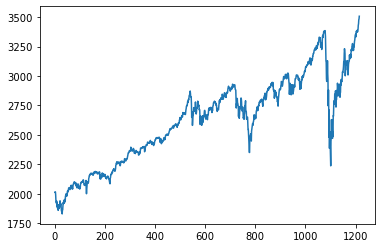

In [18]:
# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
ticker = '^GSPC'

# We would like all available data from 01/01/2000 until 12/31/2016.
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2020, 8, 30)

price = data.DataReader(['sp500'], 'fred', start, end).ffill().bfill()
log_price = np.log(price)
log_price = log_price.values
plt.plot(np.exp(log_price))

In [19]:
sig=LPPL_confidence_signal(log_price=log_price, time=range(700,1200,20), time_windows=range(300,745,5))

t2:700
(50_w,100)-aCMA-ES (mu_w=27.0,w_1=8%) in dimension 3 (seed=703052, Wed Sep  9 14:19:36 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    100 3.167517089363255e+02 1.0e+00 3.21e+00  4e+00  4e+00 0:00.1
    2    200 2.833630653071154e+02 1.5e+00 4.88e+00  4e+00  7e+00 0:00.2
    3    300 2.813930754100895e+02 2.4e+00 5.02e+00  1e+00  6e+00 0:00.2
NOTE (module=cma, iteration=20):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 2.4e+07 to 2.5e+00
   32   3200 2.276856072936538e+02 4.2e+02 3.22e+00  8e-08  2e-01 0:03.4
   75   7500 2.042998854048931e+02 5.5e+00 3.90e+00  7e-10  3e-05 0:07.4
  100  10000 2.042102798142471e+02 9.2e+03 1.84e+02  1e-08  3e-03 0:09.5
NOTE (module=cma, iteration=100):  
condition in coordinate system exceeded 2.0e+08, rescaled to 1.0e+00, 
condition changed from 8.4e+07 to 1.1e+01
  145  14500 2.042034143845036e+02 8.6e+03 1.53e+02  2e-10  5e-08 0:13.1
termination on tolfu

KeyboardInterrupt: 

In [ ]:
plot_lppls(log_price,sig,price.index)